In [15]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt 
%matplotlib inline


import os

import json

import itertools

from pickle import load,dump

from sklearn.model_selection import KFold,StratifiedKFold,LeaveOneOut,ShuffleSplit,cross_val_score,GridSearchCV, RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
from sklearn.model_selection import train_test_split


In [2]:
with open('target', 'rb') as pickle_file:
    y = load(pickle_file)

In [3]:
with open('norm_frames', 'rb') as pickle_file:
    X = load(pickle_file)

In [4]:
class_labels = {}

class_labels[0] = 'correct'
class_labels[1] = 'incorrect_chin_tuck'
class_labels[2] = 'incorrect_lean_fwd'
class_labels[3] = 'incorrect_feet_close'
class_labels[4] = 'incorrect_not_low'
class_labels[5] = 'incorrect_out_knees'

# PCA


In [5]:
from sklearn.decomposition import KernelPCA, PCA
from sklearn.preprocessing import StandardScaler


In [6]:
pca = PCA(n_components = 40)
pca.fit(X)

PCA(n_components=40)

Text(0, 0.5, 'Explained variance')

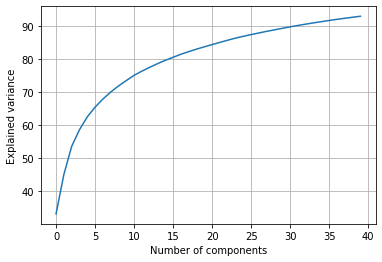

In [7]:
plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')

In [8]:
X_t = pca.transform(X)
X_t.shape

(296, 40)

## Visualising the dataset

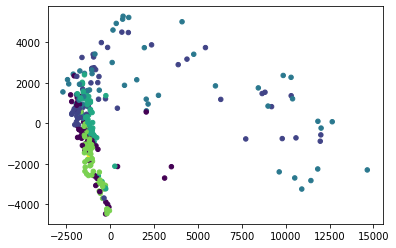

In [9]:
pca_2 = PCA(n_components = 2)

pca_2.fit(X)
X_t2 = pca_2.transform(X)

plt.scatter(X_t2[:,0],X_t2[:,1],c=y, s= 20)



## Creating the different folds to be used when scoring the models


In [127]:
k_folds = KFold(n_splits = 5)
sk_folds = StratifiedKFold(n_splits = 5)
loo = LeaveOneOut()
ss = ShuffleSplit(train_size=0.7, test_size=0.2, n_splits = 5)
labels = ['correct','incorrect_chin_tuck','incorrect_lean_fwd','incorrect_feet_close','incorrect_not_low']
cross_vals = ['K_fold','Stratified_K_fold','Leave_One_Out','Shuffle_split']



## Support Vector Classifier


In [66]:
from sklearn.svm import SVC


In [17]:

X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.1, random_state=42)

In [76]:
svc = SVC(C=48)

svc.fit(X_train,y_train)
svc.score(X_test,y_test)

0.9333333333333333

In [77]:
scores = cross_val_score(svc, X, y, cv = ss)

In [78]:
C_val = np.arange(1,101)

In [70]:
accuracies = []
for i in C_val:
    svc = SVC(C=i)
    svc.fit(X_train,y_train)
    score = svc.score(X_test,y_test)
    accuracies.append(score)
    

In [71]:

accuracies_linear = []
for i in C_val:
    svc = SVC(C=i,kernel='linear')
    svc.fit(X_train,y_train)
    score = svc.score(X_test,y_test)
    accuracies_linear.append(score)


In [72]:
accuracies_sigmoid = []
for i in C_val:
    svc = SVC(C=i,kernel='sigmoid')
    svc.fit(X_train,y_train)
    score = svc.score(X_test,y_test)
    accuracies_sigmoid.append(score)


In [73]:
accuracies_poly = []
for i in C_val:
    svc = SVC(C=i,kernel='poly')
    svc.fit(X_train,y_train)
    score = svc.score(X_test,y_test)
    accuracies_poly.append(score)


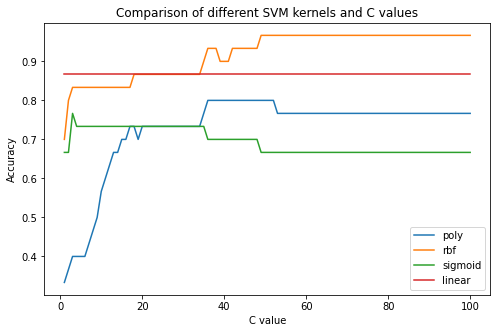

In [74]:
plt.figure(figsize=(8,5))
plt.title("Comparison of different SVM kernels and C values")
plt.xlabel("C value")
plt.ylabel("Accuracy")
plt.plot(C_val,accuracies_poly,label='poly')
plt.plot(C_val,accuracies,label='rbf')
plt.plot(C_val,accuracies_sigmoid,label='sigmoid')
plt.plot(C_val,accuracies_linear,label = 'linear')
plt.legend()
plt.show()



In [75]:
print(accuracies.index(max(accuracies)))

48


In [82]:
scores_kf_f1 = cross_val_score(svc, X, y, cv = k_folds,scoring='f1_micro')
scores_skf_f1 = cross_val_score(svc, X, y, cv = sk_folds,scoring='f1_micro')
scores_loo_f1 = cross_val_score(svc, X, y, cv = loo,scoring='f1_micro')
scores_ss_f1 = cross_val_score(svc, X, y, cv = ss,scoring='f1_micro')


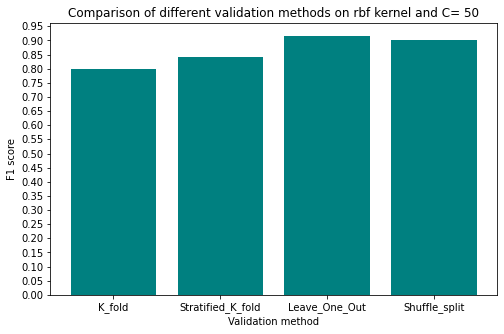

In [83]:
results = [scores_kf_f1.mean(),scores_skf_f1.mean(),scores_loo_f1.mean(),scores_ss_f1.mean()]


plt.figure(figsize=(8,5))
plt.title("Comparison of different validation methods on rbf kernel and C= 50")
plt.xlabel("Validation method")
plt.ylabel("F1 score")
plt.yticks(np.arange(0, 1, 0.05))
plt.bar(cross_vals,results,color='teal')
plt.show() 


In [24]:
cross_vals = ['K_fold','Stratified_K_fold','Leave_One_Out','Shuffle_split']


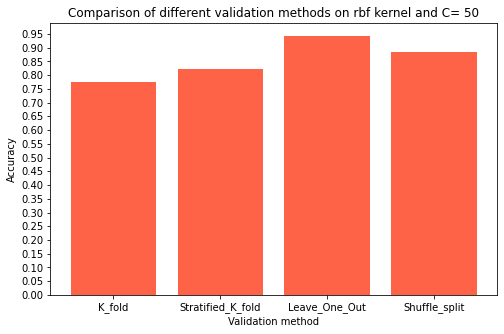

In [26]:
cross_vals = ['K_fold','Stratified_K_fold','Leave_One_Out','Shuffle_split']
results = [scores_kf.mean(),scores_skf.mean(),scores_loo.mean(),scores_ss.mean()]

plt.figure(figsize=(8,5))
plt.title("Comparison of different validation methods on rbf kernel and C= 50")
plt.xlabel("Validation method")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 1, 0.05))
plt.bar(cross_vals,results,color = 'tomato')
plt.show() 


In [87]:
print(scores_ss_f1.mean(), "ss")
print(scores_kf_f1.mean(), "kf")
print(scores_loo_f1.mean(), "loo")
print(scores_skf_f1.mean(), "skf")



0.9 ss
0.7972316384180791 kf
0.9155405405405406 loo
0.8410734463276837 skf


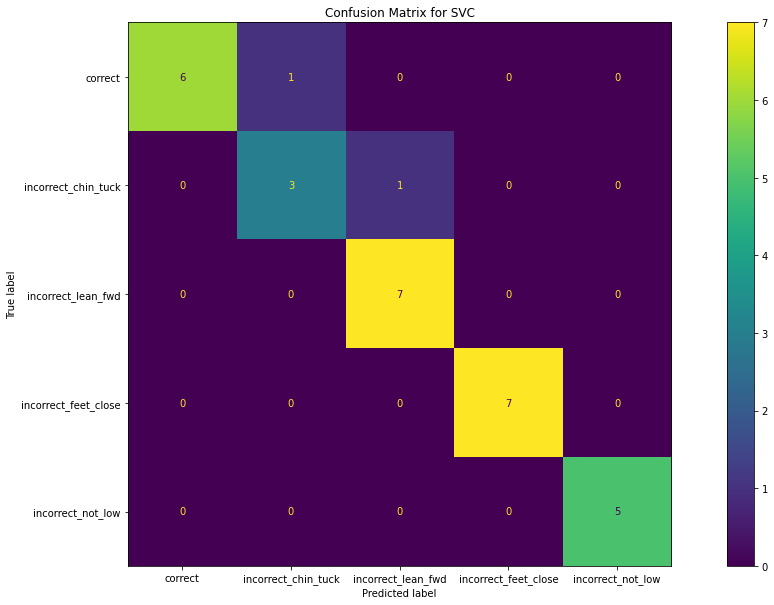

In [88]:
predictions = svc.predict(X_test)
fig, ax = plt.subplots(figsize=(20, 10))
ConfusionMatrixDisplay.from_predictions(y_test, predictions,ax=ax,display_labels=labels)

# set the title and axis labels for the plot
plt.title('Confusion Matrix for SVC')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# show the plot
plt.show()

# KNC

In [11]:
from sklearn.neighbors import KNeighborsClassifier as KNC


In [18]:
n_neighbors = np.arange(3,20)
weights = ['uniform','distance']
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
params = {'n_neighbors':n_neighbors, 'weights':weights,'algorithm':algorithm,'p':[2]}


knc = KNC()
knc_tuning = RandomizedSearchCV(knc, params, scoring='accuracy', n_iter=30, cv=3, verbose=2)

knc_tuning.fit(X_train,y_train)



Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END algorithm=ball_tree, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, n_neighbors=9, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, n_neighbors=13, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, n_neighbors=13, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, n_neighbors=13, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=ball_tree, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=ball_tree, n_neighbors=5, p=2, weights=uniform; total time=   0.0s
[CV] END algorithm=kd_tree, n_neighbors=16, p=2, weights=distance; total time=   0.0s
[CV] END algorithm=kd_tree, n_neighbors=16, p=2, weights=distance; total 

RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=30,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'n_neighbors': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                                        'p': [2],
                                        'weights': ['uniform', 'distance']},
                   scoring='accuracy', verbose=2)

In [19]:
knc_tuning.best_params_

{'weights': 'distance', 'p': 2, 'n_neighbors': 3, 'algorithm': 'kd_tree'}

In [20]:
knc = KNC(n_neighbors = 3, p = 2, algorithm = 'kd_tree',weights='distance')


In [21]:
knc.fit(X_train,y_train)
knc.score(X_test,y_test)

0.8333333333333334

In [22]:
scores_kf_knc = cross_val_score(knc, X, y, cv = k_folds, scoring='f1_micro')
scores_skf_knc = cross_val_score(knc, X, y, cv = sk_folds, scoring='f1_micro')
scores_loo_knc = cross_val_score(knc, X, y, cv = loo, scoring='f1_micro')
scores_ss_knc = cross_val_score(knc, X, y, cv = ss, scoring='f1_micro')

In [27]:
print(scores_kf_knc.mean(),"k_fold")
print(scores_skf_knc.mean(),"stratified k_fold")
print(scores_loo_knc.mean(),"loo")
print(scores_ss_knc.mean(),"ss")



0.6357062146892656 k_fold
0.6866666666666668 stratified k_fold
0.8716216216216216 loo
0.8366666666666667 ss


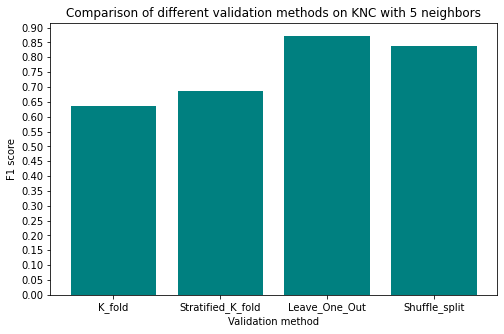

In [25]:
results_knc = [scores_kf_knc.mean(),scores_skf_knc.mean(),scores_loo_knc.mean(),scores_ss_knc.mean()]

plt.figure(figsize=(8,5))
plt.title("Comparison of different validation methods on KNC with 5 neighbors")
plt.xlabel("Validation method")
plt.ylabel("F1 score")
plt.yticks(np.arange(0, 1, 0.05))
plt.bar(cross_vals,results_knc,color='teal')
plt.show()

In [36]:
scores_kf_knc = cross_val_score(knc, X, y, cv = k_folds)
scores_skf_knc = cross_val_score(knc, X, y, cv = sk_folds)
scores_loo_knc = cross_val_score(knc, X, y, cv = loo)
scores_ss_knc = cross_val_score(knc, X, y, cv = ss)

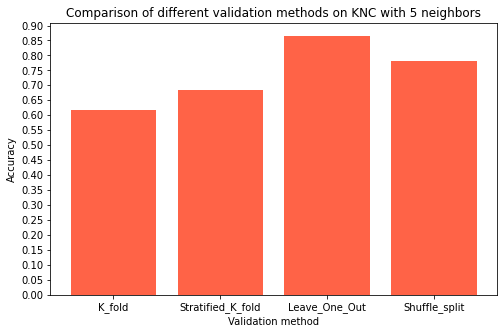

In [37]:
results_knc = [scores_kf_knc.mean(),scores_skf_knc.mean(),scores_loo_knc.mean(),scores_ss_knc.mean()]

plt.figure(figsize=(8,5))
plt.title("Comparison of different validation methods on KNC with 5 neighbors")
plt.xlabel("Validation method")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 1, 0.05))
plt.bar(cross_vals,results_knc,color='tomato')
plt.show()

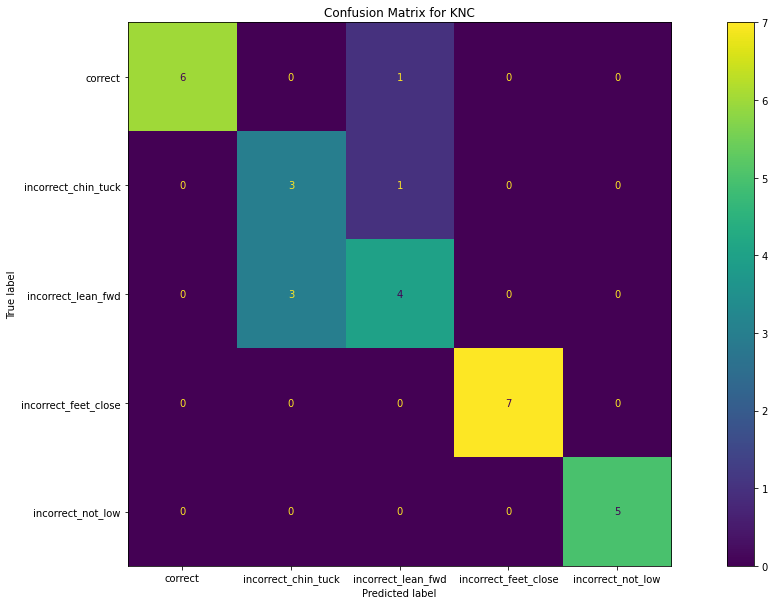

In [30]:
predictions_knc = knc.predict(X_test)
fig, ax = plt.subplots(figsize=(20, 10))
ConfusionMatrixDisplay.from_predictions(y_test, predictions_knc,ax=ax,display_labels=labels)

# set the title and axis labels for the plot
plt.title('Confusion Matrix for KNC')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# show the plot
plt.show()

# Decision Tree

In [31]:
from sklearn.tree import DecisionTreeClassifier as DTC

In [32]:
dtc = DTC()
dtc.fit(X_train,y_train)
dtc.score(X_test,y_test)

0.6

In [33]:
criterion = ['gini', 'entropy', 'log_loss']
max_depth = np.arange(1,150)
random_state = np.arange(0,300)
max_leaf_nodes = np.arange(1,150)
params ={'criterion':criterion,'max_depth':max_depth,'random_state':random_state,'max_leaf_nodes':max_leaf_nodes}


dtc_tuning = RandomizedSearchCV(dtc, params, scoring='accuracy', n_iter=30, cv=3, verbose=2)

dtc_tuning.fit(X_train,y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END criterion=log_loss, max_depth=45, max_leaf_nodes=49, random_state=227; total time=   0.0s
[CV] END criterion=log_loss, max_depth=45, max_leaf_nodes=49, random_state=227; total time=   0.0s
[CV] END criterion=log_loss, max_depth=45, max_leaf_nodes=49, random_state=227; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_leaf_nodes=99, random_state=279; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_leaf_nodes=99, random_state=279; total time=   0.0s
[CV] END criterion=gini, max_depth=40, max_leaf_nodes=99, random_state=279; total time=   0.0s
[CV] END criterion=log_loss, max_depth=69, max_leaf_nodes=53, random_state=256; total time=   0.0s
[CV] END criterion=log_loss, max_depth=69, max_leaf_nodes=53, random_state=256; total time=   0.0s
[CV] END criterion=log_loss, max_depth=69, max_leaf_nodes=53, random_state=256; total time=   0.0s
[CV] END criterion=entropy, max_depth=23, max_leaf_nodes=74,

RandomizedSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_iter=30,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  7...
       208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
       221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
       234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246,
       247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259,
       260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272,
       273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285,
       286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298,
       299])},
                   scoring='accuracy', verbose=2)

In [34]:
dtc_tuning.best_params_

{'random_state': 22,
 'max_leaf_nodes': 85,
 'max_depth': 17,
 'criterion': 'log_loss'}

In [36]:
dtc_tuned = DTC(random_state = 22, max_leaf_nodes = 85, max_depth = 17, criterion = 'log_loss')
dtc_tuned.fit(X_train,y_train)
dtc_tuned.score(X_test,y_test)

0.7

In [37]:
scores_kf_dtc = cross_val_score(dtc_tuned, X, y, cv = k_folds, scoring='f1_micro')
scores_skf_dtc = cross_val_score(dtc_tuned, X, y, cv = sk_folds, scoring='f1_micro')
scores_loo_dtc = cross_val_score(dtc_tuned, X, y, cv = loo, scoring='f1_micro')
scores_ss_dtc = cross_val_score(dtc_tuned, X, y, cv = ss, scoring='f1_micro')

In [38]:
print(scores_kf_dtc.mean(),"k_fold")
print(scores_skf_dtc.mean(),"stratified k_fold")
print(scores_loo_dtc.mean(),"loo")
print(scores_ss_dtc.mean(),"ss")



0.594858757062147 k_fold
0.6959887005649718 stratified k_fold
0.7972972972972973 loo
0.7833333333333333 ss


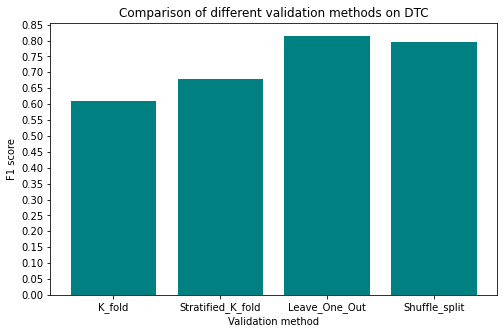

In [45]:
results_dtc = [scores_kf_dtc.mean(),scores_skf_dtc.mean(),scores_loo_dtc.mean(),scores_ss_dtc.mean()]

plt.figure(figsize=(8,5))
plt.title("Comparison of different validation methods on DTC")
plt.xlabel("Validation method")
plt.ylabel("F1 score")
plt.yticks(np.arange(0, 1, 0.05))
plt.bar(cross_vals,results_dtc,color='teal')
plt.show()

In [74]:
scores_kf_dtc = cross_val_score(dtc_tuned, X, y, cv = k_folds)
scores_skf_dtc = cross_val_score(dtc_tuned, X, y, cv = sk_folds)
scores_loo_dtc = cross_val_score(dtc_tuned, X, y, cv = loo)
scores_ss_dtc = cross_val_score(dtc_tuned, X, y, cv = ss)

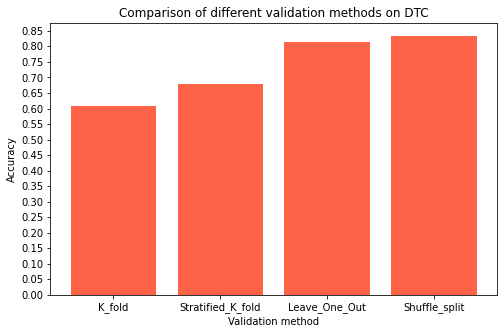

In [75]:
results_dtc = [scores_kf_dtc.mean(),scores_skf_dtc.mean(),scores_loo_dtc.mean(),scores_ss_dtc.mean()]

plt.figure(figsize=(8,5))
plt.title("Comparison of different validation methods on DTC")
plt.xlabel("Validation method")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 1, 0.05))
plt.bar(cross_vals,results_dtc,color='tomato')
plt.show()

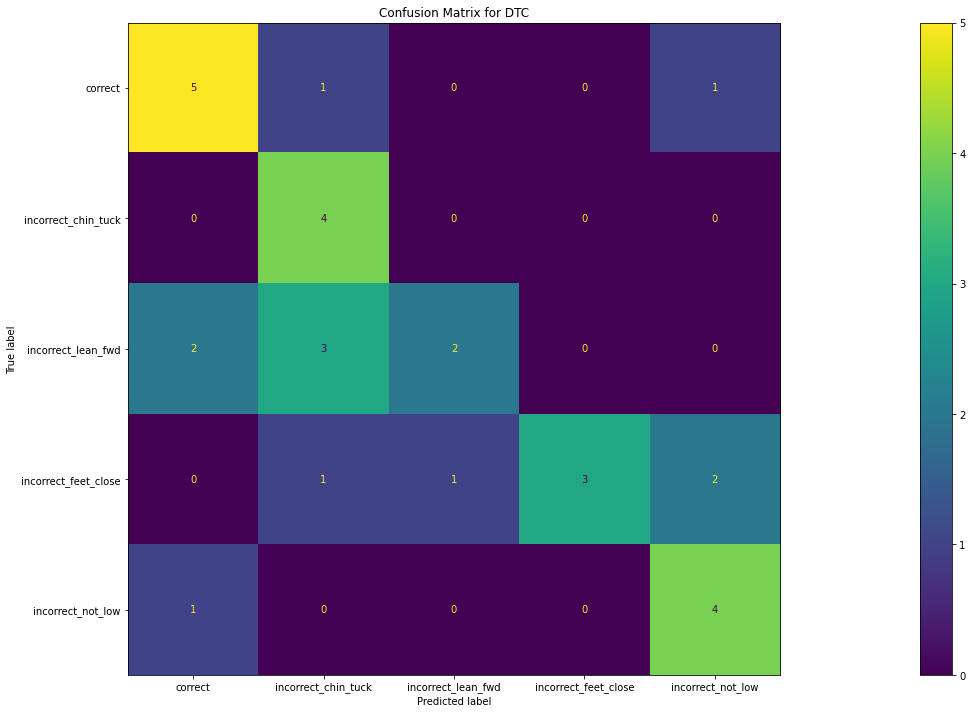

In [39]:
labels_dtc = ['correct','incorrect_chin_tuck','incorrect_lean_fwd','incorrect_feet_close','incorrect_not_low','incorrect_out_knees']

predictions_dtc = dtc.predict(X_test)
fig, ax = plt.subplots(figsize=(50, 12))
ConfusionMatrixDisplay.from_predictions(y_test, predictions_dtc,ax=ax,display_labels=labels_dtc[:5])

# set the title and axis labels for the plot
plt.title('Confusion Matrix for DTC')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# show the plot
plt.show()

# Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier as RFC

In [43]:
rfc = RFC(15,random_state = 22, max_leaf_nodes = 85, max_depth = 17, criterion = 'log_loss')

In [44]:
rfc.fit(X_train,y_train)
rfc.score(X_test,y_test)

0.8

In [45]:
num_models = np.arange(1,31)
scores_rfc =[]
for i in num_models:
    rfc = RFC(i,random_state = 262, max_leaf_nodes = 130, max_depth = 120, criterion = 'entropy')
    rfc.fit(X_train,y_train)
    score =rfc.score(X_test,y_test)
    scores_rfc.append(score)
    

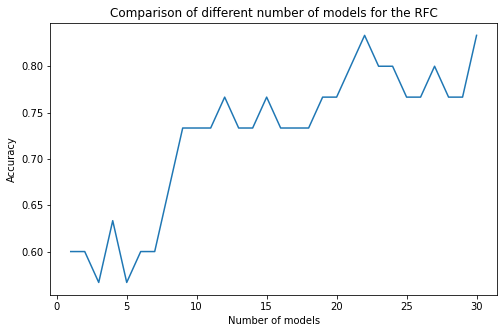

In [46]:
plt.figure(figsize=(8,5))
plt.title("Comparison of different number of models for the RFC")
plt.xlabel("Number of models")
plt.ylabel("Accuracy")
plt.plot(num_models,scores_rfc)

In [50]:
print(scores_rfc.index(max(scores_rfc)))

21


In [51]:

rfc_tuned = RFC(21,random_state = 262, max_leaf_nodes = 130, max_depth = 120, criterion = 'entropy')
rfc_tuned.fit(X_train,y_train)


RandomForestClassifier(criterion='entropy', max_depth=120, max_leaf_nodes=130,
                       n_estimators=21, random_state=262)

In [52]:
scores_kf_rfc = cross_val_score(rfc_tuned, X, y, cv = k_folds, scoring='f1_micro')
scores_skf_rfc = cross_val_score(rfc_tuned, X, y, cv = sk_folds, scoring='f1_micro')
scores_loo_rfc = cross_val_score(rfc_tuned, X, y, cv = loo, scoring='f1_micro')
scores_ss_rfc = cross_val_score(rfc_tuned, X, y, cv = ss, scoring='f1_micro')


In [53]:
print(scores_kf_rfc.mean(),"k_fold")
print(scores_skf_rfc.mean(),"stratified k_fold")
print(scores_loo_rfc.mean(),"loo")
print(scores_ss_rfc.mean(),"ss")



0.7404519774011299 k_fold
0.7838418079096046 stratified k_fold
0.9324324324324325 loo
0.8866666666666667 ss


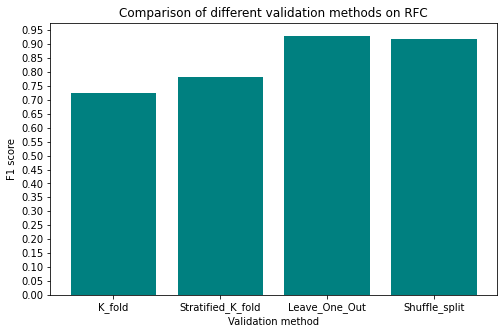

In [54]:
results_rfc = [scores_kf_rfc.mean(),scores_skf_rfc.mean(),scores_loo_rfc.mean(),scores_ss_rfc.mean()]

plt.figure(figsize=(8,5))
plt.title("Comparison of different validation methods on RFC")
plt.xlabel("Validation method")
plt.ylabel("F1 score")
plt.yticks(np.arange(0, 1, 0.05))
plt.bar(cross_vals,results_rfc,color='teal')
plt.show()

In [55]:
print(results_rfc)
print(results_dtc)

[0.723502824858757, 0.7803954802259887, 0.9290540540540541, 0.9166666666666666]
[0.6084745762711865, 0.6792090395480226, 0.8141891891891891, 0.7966666666666666]


In [84]:
scores_kf_rfc = cross_val_score(rfc_tuned, X, y, cv = k_folds)
scores_skf_rfc = cross_val_score(rfc_tuned, X, y, cv = sk_folds)
scores_loo_rfc = cross_val_score(rfc_tuned, X, y, cv = loo)
scores_ss_rfc = cross_val_score(rfc_tuned, X, y, cv = ss)

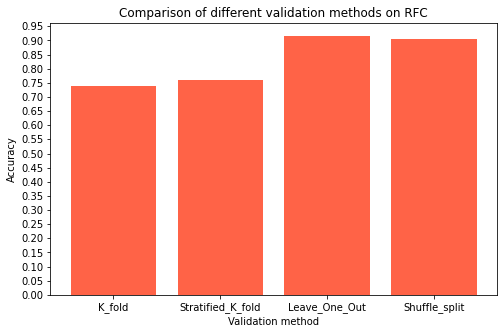

In [86]:
results_rfc = [scores_kf_rfc.mean(),scores_skf_rfc.mean(),scores_loo_rfc.mean(),scores_ss_rfc.mean()]

plt.figure(figsize=(8,5))
plt.title("Comparison of different validation methods on RFC")
plt.xlabel("Validation method")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 1, 0.05))
plt.bar(cross_vals,results_rfc,color='tomato')
plt.show()

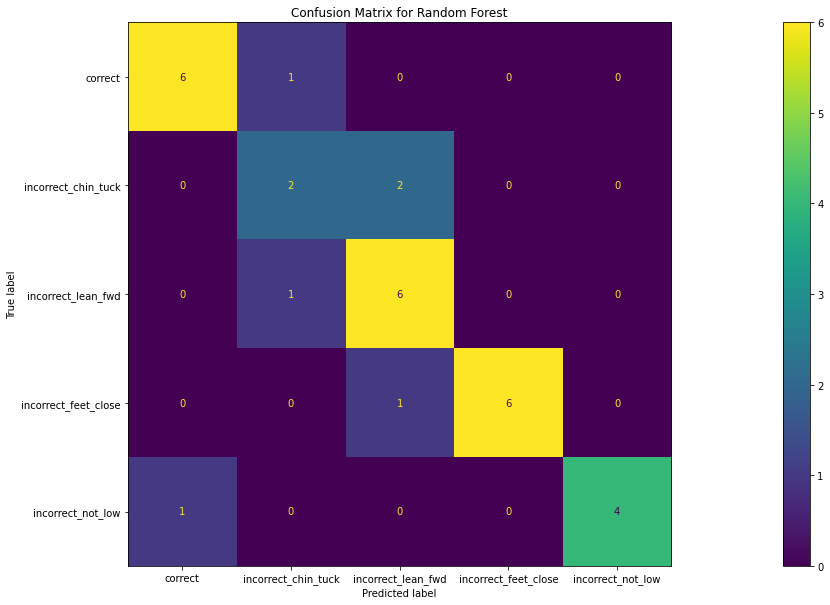

In [54]:
predictions_rfc = rfc_tuned.predict(X_test)
fig, ax = plt.subplots(figsize=(40, 10))
ConfusionMatrixDisplay.from_predictions(y_test, predictions_rfc,ax=ax,display_labels=labels)

# set the title and axis labels for the plot
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# show the plot
plt.show()

## SMOTEENN

In [55]:
from imblearn.over_sampling import ADASYN,SMOTE,BorderlineSMOTE
from imblearn.combine import SMOTEENN

In [56]:
smoteenn = SMOTEENN(smote=SMOTE(k_neighbors=4), random_state=42, sampling_strategy='not majority')


In [57]:
X_resampled, y_resampled = smoteenn.fit_resample(X_t, y)

In [58]:
X_resampled.shape

(336, 40)

In [91]:
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_resampled,y_resampled, test_size=0.1, random_state=42)

In [90]:
k_folds = KFold(n_splits = 5)
sk_folds = StratifiedKFold(n_splits = 5)
loo = LeaveOneOut()
ss = ShuffleSplit(train_size=0.6, test_size=0.2, n_splits = 5)

## SVM on resampled dataset

In [94]:
svc = SVC(C=48)

svc.fit(X_train_res,y_train_res)



SVC(C=48)

In [95]:
scores_kf_res_f1 = cross_val_score(svc, X_resampled, y_resampled, cv = k_folds,scoring='f1_micro')
scores_skf_res_f1 = cross_val_score(svc, X_resampled, y_resampled, cv = sk_folds,scoring='f1_micro')
scores_loo_res_f1 = cross_val_score(svc, X_resampled, y_resampled, cv = loo,scoring='f1_micro')
scores_ss_res_f1 = cross_val_score(svc, X_resampled, y_resampled, cv = ss,scoring='f1_micro')


In [96]:
print(scores_kf_res_f1.mean(), "kf")
print(scores_skf_res_f1.mean(), "skf")
print(scores_loo_res_f1.mean(), "loo")
print(scores_ss_res_f1.mean(), "ss")

0.33964003511852503 kf
0.9289288849868307 skf
0.9642857142857143 loo
0.9764705882352942 ss


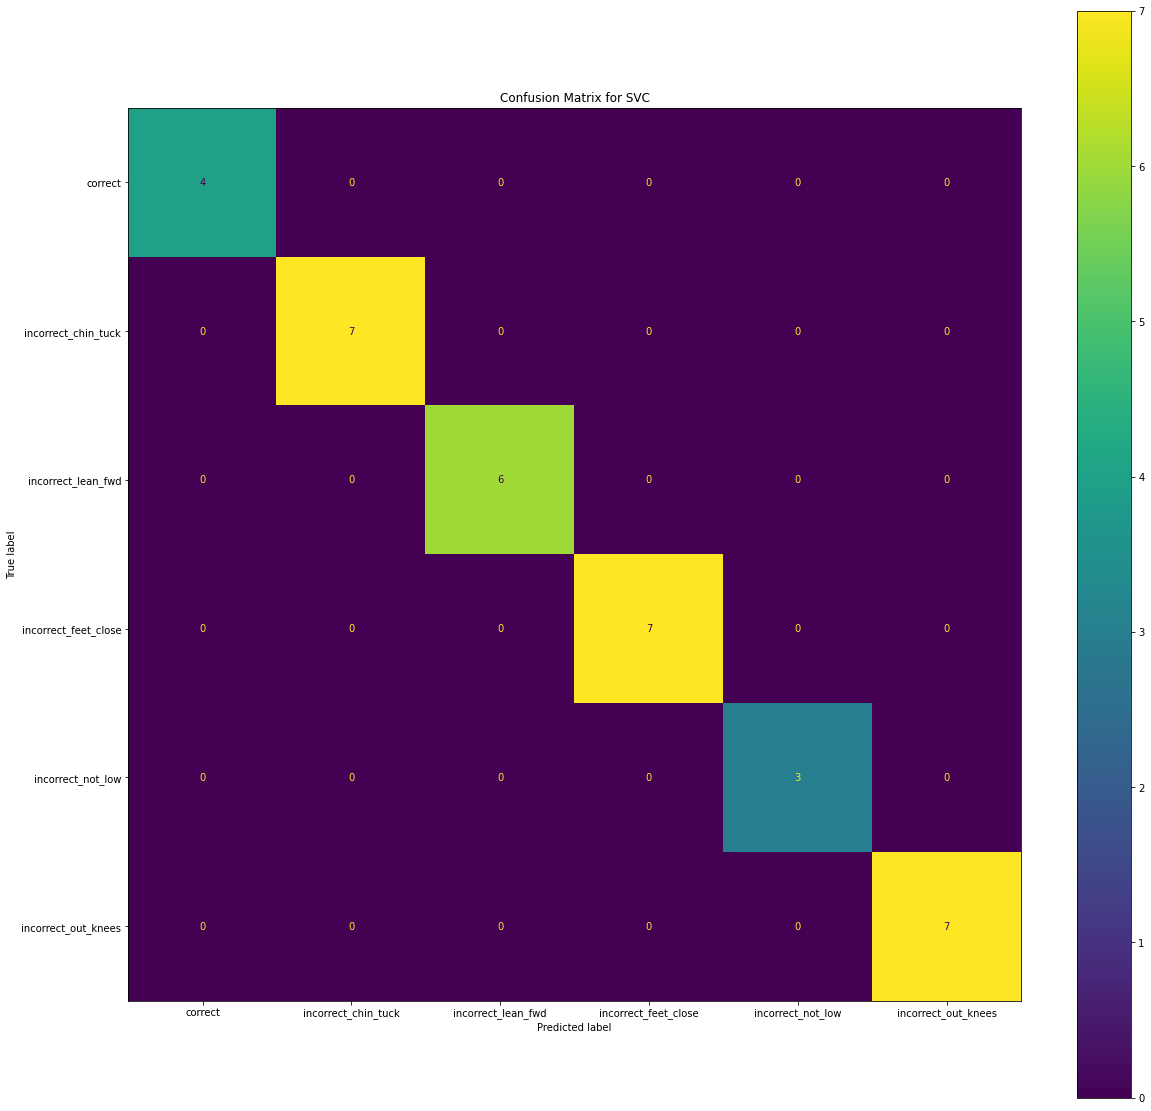

In [109]:
predictions = svc.predict(X_test_res)
fig, ax = plt.subplots(figsize=(20, 20))
labels_full = ['correct','incorrect_chin_tuck','incorrect_lean_fwd','incorrect_feet_close','incorrect_not_low','incorrect_out_knees']

ConfusionMatrixDisplay.from_predictions(y_test_res, predictions,ax=ax,display_labels=labels_full)

# set the title and axis labels for the plot
plt.title('Confusion Matrix for SVC')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# show the plot
plt.show()

## KNC on resampled dataset

In [111]:
knc = KNC(n_neighbors = 3, p = 2, algorithm = 'kd_tree',weights='distance')
knc.fit(X_train_res,y_train_res)


1.0

In [112]:
scores_kf_knc_res_f1 = cross_val_score(knc, X_resampled, y_resampled, cv = k_folds,scoring='f1_micro')
scores_skf_knc_res_f1 = cross_val_score(knc, X_resampled, y_resampled, cv = sk_folds,scoring='f1_micro')
scores_loo_knc_res_f1 = cross_val_score(knc, X_resampled, y_resampled, cv = loo,scoring='f1_micro')
scores_ss_knc_res_f1 = cross_val_score(knc, X_resampled, y_resampled, cv = ss,scoring='f1_micro')


In [113]:
print(scores_kf_knc_res_f1.mean(), "kf")
print(scores_skf_knc_res_f1.mean(), "skf")
print(scores_loo_knc_res_f1.mean(), "loo")
print(scores_ss_knc_res_f1.mean(), "ss")

0.3484635645302897 kf
0.9229587357330992 skf
0.9880952380952381 loo
0.9852941176470589 ss


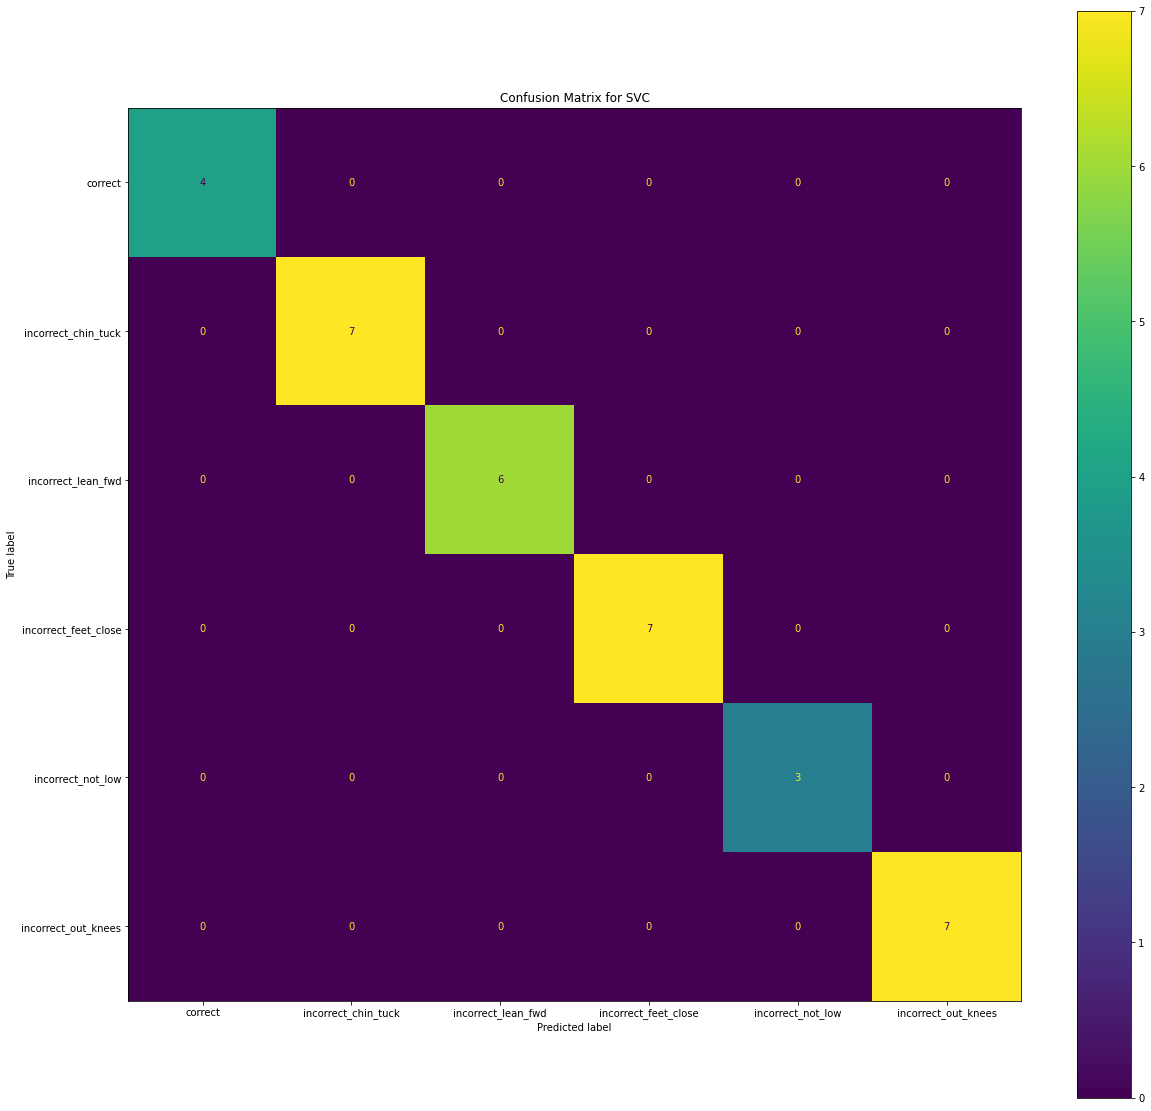

In [114]:
predictions = knc.predict(X_test_res)
fig, ax = plt.subplots(figsize=(20, 20))
labels_full = ['correct','incorrect_chin_tuck','incorrect_lean_fwd','incorrect_feet_close','incorrect_not_low','incorrect_out_knees']

ConfusionMatrixDisplay.from_predictions(y_test_res, predictions,ax=ax,display_labels=labels_full)

# set the title and axis labels for the plot
plt.title('Confusion Matrix for SVC')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# show the plot
plt.show()

## Decision Tree on resampled dataset

In [115]:
dtc_tuned = DTC(random_state = 22, max_leaf_nodes = 85, max_depth = 17, criterion = 'log_loss')
dtc_tuned.fit(X_train_res,y_train_res)


0.8235294117647058

In [116]:
scores_kf_dtc_res_f1 = cross_val_score(dtc_tuned, X_resampled, y_resampled, cv = k_folds,scoring='f1_micro')
scores_skf_dtc_res_f1 = cross_val_score(dtc_tuned, X_resampled, y_resampled, cv = sk_folds,scoring='f1_micro')
scores_loo_dtc_res_f1 = cross_val_score(dtc_tuned, X_resampled, y_resampled, cv = loo,scoring='f1_micro')
scores_ss_dtc_res_f1 = cross_val_score(dtc_tuned, X_resampled, y_resampled, cv = ss,scoring='f1_micro')


In [117]:
print(scores_kf_dtc_res_f1.mean(), "kf")
print(scores_skf_dtc_res_f1.mean(), "skf")
print(scores_loo_dtc_res_f1.mean(), "loo")
print(scores_ss_dtc_res_f1.mean(), "ss")

0.3217734855136084 kf
0.783099209833187 skf
0.8541666666666666 loo
0.8294117647058824 ss


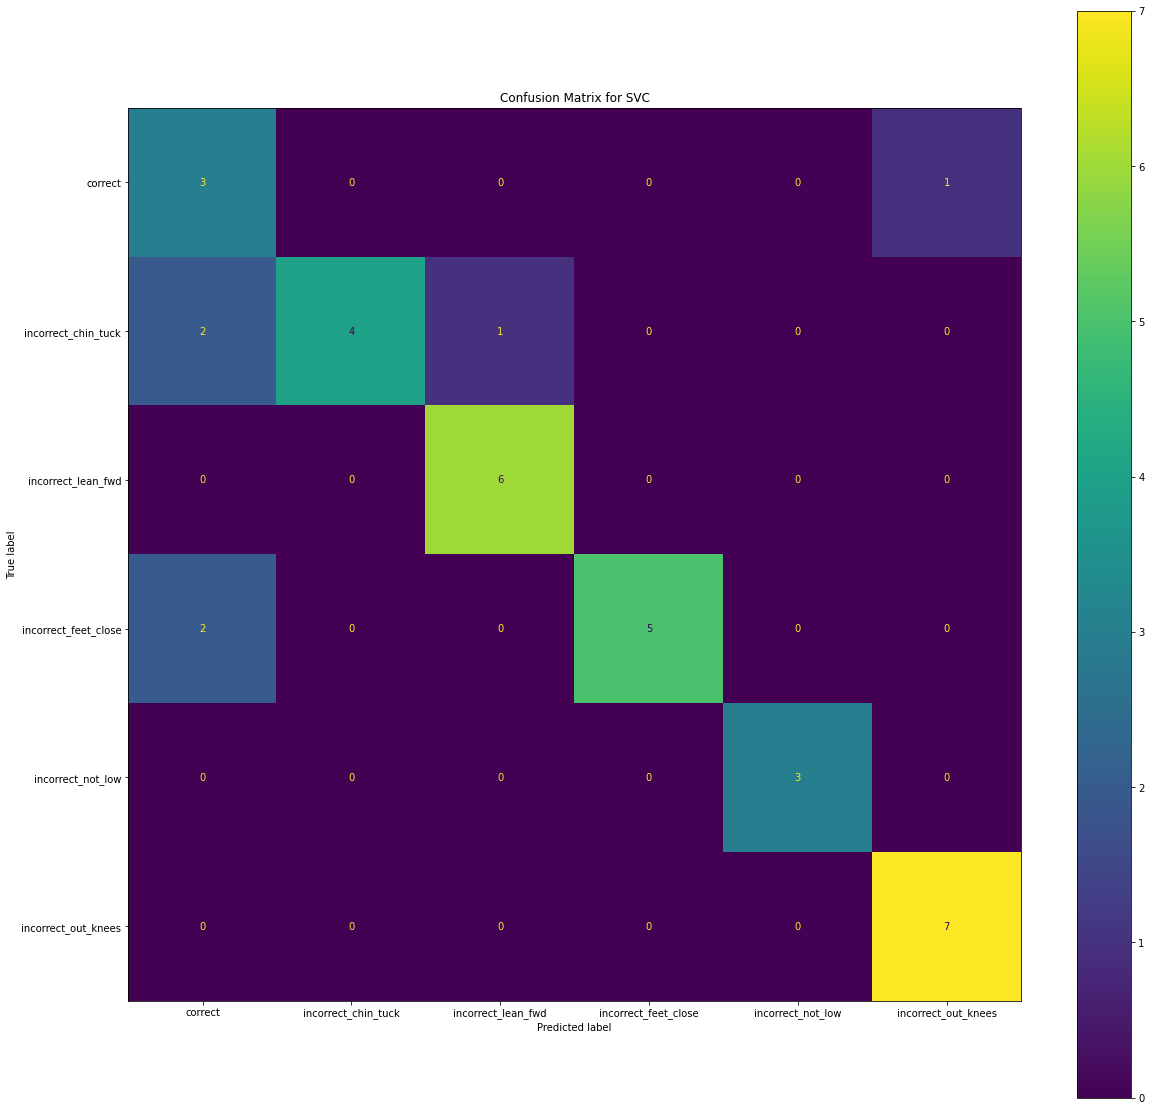

In [118]:
predictions = dtc_tuned.predict(X_test_res)
fig, ax = plt.subplots(figsize=(20, 20))
labels_full = ['correct','incorrect_chin_tuck','incorrect_lean_fwd','incorrect_feet_close','incorrect_not_low','incorrect_out_knees']

ConfusionMatrixDisplay.from_predictions(y_test_res, predictions,ax=ax,display_labels=labels_full)

# set the title and axis labels for the plot
plt.title('Confusion Matrix for SVC')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# show the plot
plt.show()

## Random forest on resampled dataset

In [121]:
rfc = RFC(15,random_state = 22, max_leaf_nodes = 85, max_depth = 17, criterion = 'log_loss')
rfc.fit(X_train_res,y_train_res)


RandomForestClassifier(criterion='log_loss', max_depth=17, max_leaf_nodes=85,
                       n_estimators=15, random_state=22)

In [122]:
scores_kf_rfc_res_f1 = cross_val_score(rfc, X_resampled, y_resampled, cv = k_folds,scoring='f1_micro')
scores_skf_rfc_res_f1 = cross_val_score(rfc, X_resampled, y_resampled, cv = sk_folds,scoring='f1_micro')
scores_loo_rfc_res_f1 = cross_val_score(rfc, X_resampled, y_resampled, cv = loo,scoring='f1_micro')
scores_ss_rfc_res_f1 = cross_val_score(rfc, X_resampled, y_resampled, cv = ss,scoring='f1_micro')


In [123]:
print(scores_kf_rfc_res_f1.mean(), "kf")
print(scores_skf_rfc_res_f1.mean(), "skf")
print(scores_loo_rfc_res_f1.mean(), "loo")
print(scores_ss_rfc_res_f1.mean(), "ss")

0.28889376646180864 kf
0.8694029850746269 skf
0.9166666666666666 loo
0.9352941176470588 ss


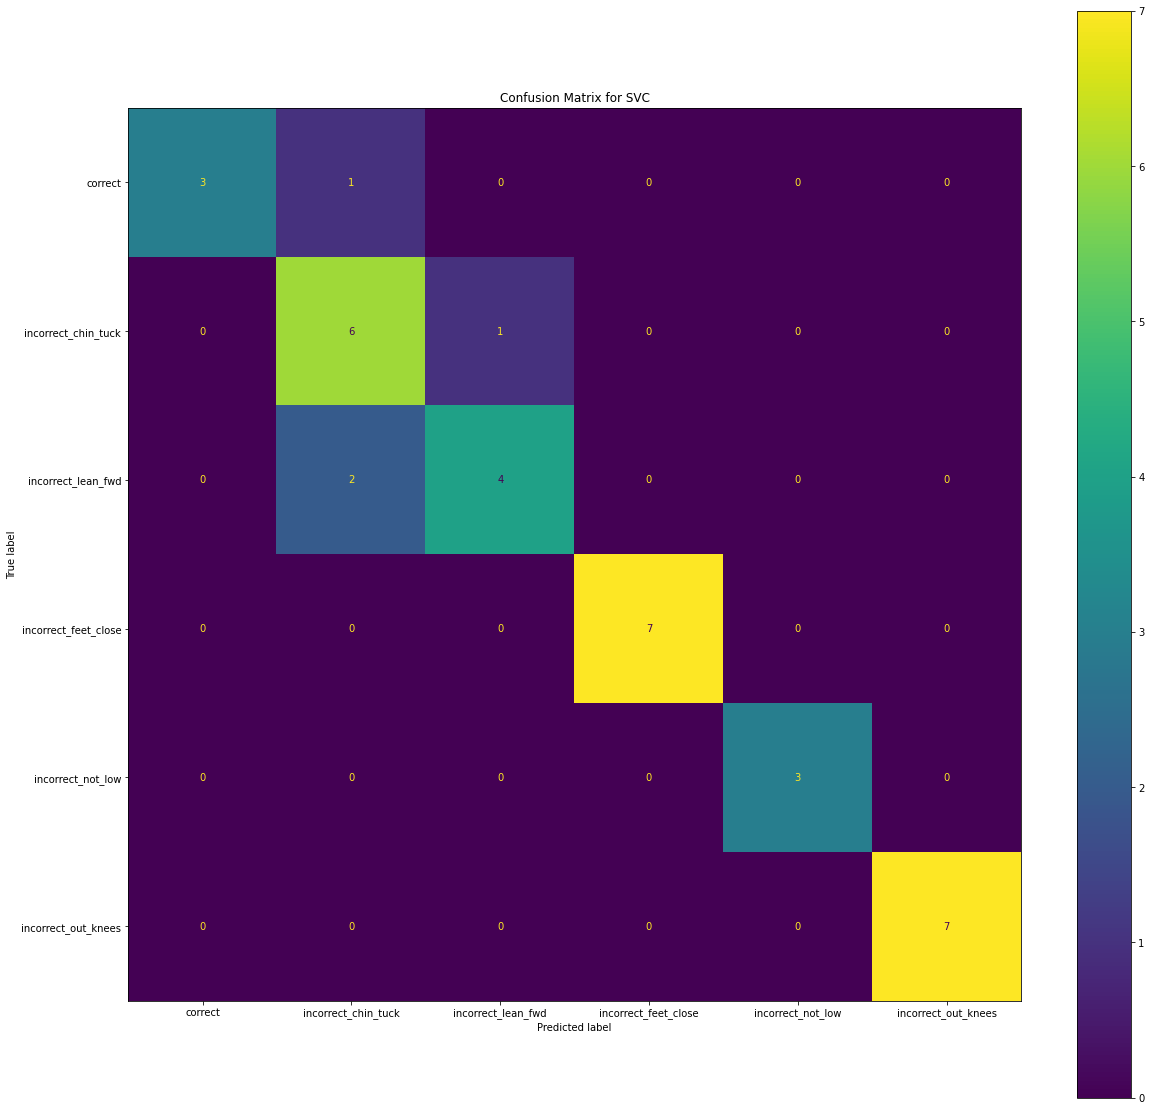

In [124]:
predictions = rfc.predict(X_test_res)
fig, ax = plt.subplots(figsize=(20, 20))
labels_full = ['correct','incorrect_chin_tuck','incorrect_lean_fwd','incorrect_feet_close','incorrect_not_low','incorrect_out_knees']

ConfusionMatrixDisplay.from_predictions(y_test_res, predictions,ax=ax,display_labels=labels_full)

# set the title and axis labels for the plot
plt.title('Confusion Matrix for SVC')
plt.xlabel('Predicted label')
plt.ylabel('True label')

# show the plot
plt.show()

## Attempt at ANN

In [64]:
from sklearn.neural_network import MLPClassifier as MLP

In [65]:
mlp = MLP((40,40,40,40,40,40,40,40,40,60,80,80,80,60,60,60,60,40,20),solver = 'lbfgs', verbose = True)

In [66]:
mlp.fit(X_train_res,y_train_res)

MLPClassifier(hidden_layer_sizes=(40, 40, 40, 40, 40, 40, 40, 40, 40, 60, 80,
                                  80, 80, 60, 60, 60, 60, 40, 20),
              solver='lbfgs', verbose=True)

In [67]:
mlp.score(X_test_res,y_test_res)

0.8787878787878788

In [68]:
scores_kf_res_mlp = cross_val_score(mlp, X_resampled, y_resampled, cv = k_folds, scoring='f1_micro')
scores_skf_res_mlp = cross_val_score(mlp, X_resampled, y_resampled, cv = sk_folds, scoring='f1_micro')
scores_loo_res_mlp = cross_val_score(mlp, X_resampled, y_resampled, cv = loo, scoring='f1_micro')
scores_ss_res_mlp = cross_val_score(mlp, X_resampled, y_resampled, cv = ss, scoring='f1_micro')

/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
S

/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
S

/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
S

/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
S

/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
S

/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/tudor/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
S

In [69]:
print(scores_kf_res_mlp.mean())
print(scores_skf_res_mlp.mean())
print(scores_loo_res_mlp.mean())
print(scores_ss_res_mlp.mean())

0.32680652680652683
0.9028438228438228
0.9270516717325228
0.884848484848485
